In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Ridge
from scipy import stats
import math

# Dataset

In [44]:
jerks_path = "Dataset/Appropriateness_Features/mean_jerk_values.csv"
XX_jerks = pd.read_csv(jerks_path) # With Spine joint and Name of "Cond/StudySeq"

accels_path = "Dataset/Appropriateness_Features/mean_acceleration_values.csv"
XX_accels = pd.read_csv(accels_path) # With Spine joint and Name of "Cond/StudySeq"

pairwise_path = "Dataset/Appropriateness_Features/mean_pairwise_joint_distances.csv"
XX_pairwise = pd.read_csv(pairwise_path) # With Spine joint and Name of "Cond/StudySeq"
XX_pairwise.drop(XX_pairwise.columns[range(1,15)], axis=1, inplace=True) # Without Spine Joint but with Name of "Cond/StudySeq"

rms_properties_path = "Dataset/Appropriateness_Features/RMS_Energy_properties.csv"
XX_rms_energy_properties = pd.read_csv(rms_properties_path, index_col = False) # With Name of StudySeq

rms_distance_path = "Dataset/Appropriateness_Features/RMS_Distance_scores_fd_scaled.csv"
XX_rms_distance_scores = pd.read_csv(rms_distance_path)
XX_rms_distance_scores.drop(XX_rms_distance_scores.columns[1], axis=1, inplace=True) # Dropping the Spine joint (always 0)

labels_path = "Dataset/Appropriateness_Labels/mean_opinion_scores.csv"
YY = pd.read_csv(labels_path) # # With Name of "Cond/StudySeq"

In [45]:
XY = XX_jerks.join(YY, lsuffix="_jerks", rsuffix="_YY")
XY = XY.join(XX_accels, rsuffix='_accels')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_accels'})
XY = XY.join(XX_pairwise, rsuffix='_pairwise')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_pairwise'})
XY = XY.join(XX_rms_distance_scores)
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_rms_distance_scores'})

In [46]:
# Join the RMS Energy Properties Features
XY = XY.rename(columns={'Unnamed: 0_jerks': 'StudySeq'})
XY['idx'] = XY['StudySeq']
XY['StudySeq'] = XY['StudySeq'].apply(lambda x: x[8:])
XY = XY.join(XX_rms_energy_properties, rsuffix='_rms')
for i in range(1,int(XY.shape[0]/40)):
    XY.iloc[i*40:(i+1)*40,-5:] = XX_rms_energy_properties

In [47]:
# Drop the Names of "Cond/StudySeq" and remaining information relating to the "Spine" joint
# Also Drop the Index from rms_energy
XY.drop(['StudySeq','Unnamed: 0_YY','Unnamed: 0_accels', 'Unnamed: 0_pairwise', 'Spine', 'Spine_accels',
        'Unnamed: 0_rms_distance_scores', 'Unnamed: 0', 'StudySeq_rms'], axis=1, inplace=True)

rename_dict = dict(zip(XY.columns[0:14], XY.columns[0:14] + '_jerks'))
XY = XY.rename(columns=rename_dict)
XY.set_index('idx', inplace=True)
# Jerk for 14 joints + Acceleration for 14 joints + 14 choose 2 pairwise distance + 14 RMS Energy Distance Scores + 3 RMS Energy Property Features + Label for MOS = 137
print(XY.shape)

(360, 137)


In [48]:
XX = XY.drop(['Mean_Appropriateness_Score'], axis=1, inplace=False)
YY = XY.loc[:,'Mean_Appropriateness_Score']
XX = np.log(XX)
print(XX.shape)
print(YY.shape)

(360, 136)
(360,)


In [49]:
XX

,Spine1_jerks,Spine2_jerks,Spine3_jerks,LeftShoulder_jerks,LeftArm_jerks,LeftForearm_jerks,LeftHand_jerks,RightShoulder_jerks,RightArm_jerks,RightForearm_jerks,...,RightShoulder_RMS_Distance_Score,RightArm_RMS_Distance_Score,RightForeArm_RMS_Distance_Score,RightHand_RMS_Distance_Score,Neck_RMS_Distance_Score,Neck1_RMS_Distance_Score,Head_RMS_Distance_Score,min_RMS_Energy,max_RMS_Energy,mean_RMS_Energy
idx,,,,,,,,,,,,,,,,,,,,,
Cond_BA/StudySeq1,4.685833,5.411104,5.878632,6.194287,6.654608,7.431837,8.474055,6.194249,6.474088,7.639084,...,-0.883697,-0.720384,-0.725393,-0.405569,-0.877568,-0.900200,-0.897108,-7.443251,-2.481649,-3.431537
Cond_BA/StudySeq2,4.794414,5.491201,5.933963,6.253794,6.713159,7.475203,8.674891,6.253755,6.409670,7.597684,...,-0.634781,-0.490504,-0.701013,-0.364630,-0.611639,-0.624665,-0.621450,-6.103462,-2.012080,-3.357033
Cond_BA/StudySeq3,4.641790,5.373085,5.848681,6.152784,6.634901,7.446747,8.324778,6.152773,6.423095,7.634566,...,-0.961857,-0.839776,-0.697355,-0.379593,-0.964247,-0.998867,-0.995880,-6.900108,-2.392672,-3.799317
Cond_BA/StudySeq4,4.542846,5.256153,5.713922,6.057099,6.488468,7.652750,8.665599,6.057132,6.482450,8.016873,...,-0.817813,-0.592928,-0.706693,-0.388299,-0.814075,-0.817477,-0.791424,-7.475503,-2.448848,-3.595032
Cond_BA/StudySeq5,4.344198,5.028202,5.490168,5.835539,6.388440,7.772797,8.492025,5.835528,6.345554,8.034707,...,-0.875800,-0.718347,-0.729312,-0.403087,-0.872548,-0.898013,-0.893621,-7.424981,-2.220725,-3.847157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cond_SE/StudySeq36,4.967658,5.675472,6.141858,6.474946,6.803089,7.614594,8.627233,6.474991,6.756016,7.909899,...,-0.862010,-0.640253,-0.729041,-0.302450,-0.852867,-0.856264,-0.844969,-7.093804,-2.782008,-4.132883
Cond_SE/StudySeq37,5.223548,5.940617,6.413427,6.708183,6.957730,7.672844,8.686264,6.708236,6.932257,7.830544,...,-0.814639,-0.664621,-0.732615,-0.407942,-0.801910,-0.813247,-0.803353,-7.536428,-3.115141,-4.425146
Cond_SE/StudySeq38,4.905687,5.614416,6.066102,6.359770,6.649041,7.214690,8.159950,6.359816,6.534368,7.303212,...,-0.876519,-0.662159,-0.709351,-0.395707,-0.876576,-0.896846,-0.887541,-7.799489,-2.971026,-4.295128


198.63134441390312


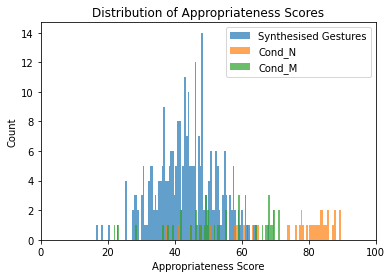

In [50]:
plt.hist(YY.loc[np.array(['Cond_N' not in idx for idx in YY.index]) & np.array(['Cond_M' not in idx for idx in YY.index])], bins = 100, label='Synthesised Gestures', alpha=0.7)
plt.hist(YY.loc[['Cond_N' in idx for idx in YY.index]], bins = 100, label='Cond_N', alpha=0.7)
plt.hist(YY.loc[['Cond_M' in idx for idx in YY.index]], bins = 100, label='Cond_M', alpha=0.7)
plt.xlim(0,100)
plt.xlabel("Appropriateness Score")
plt.ylabel("Count")
plt.title("Distribution of Appropriateness Scores")
plt.legend()
var = np.var(YY)
print(var)

198.63134441390312


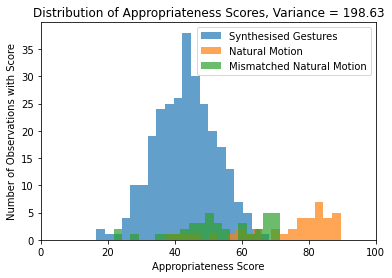

In [51]:
plt.hist(YY.loc[np.array(['Cond_N' not in idx for idx in YY.index]) & np.array(['Cond_M' not in idx for idx in YY.index])], bins = 20, label='Synthesised Gestures', alpha=0.7)
plt.hist(YY.loc[['Cond_N' in idx for idx in YY.index]], bins = 20, label='Natural Motion', alpha=0.7)
plt.hist(YY.loc[['Cond_M' in idx for idx in YY.index]], bins = 20, label='Mismatched Natural Motion', alpha=0.7)
plt.xlim(0,100)
plt.xlabel("Appropriateness Score")
plt.ylabel("Number of Observations with Score")
plt.title("Distribution of Appropriateness Scores, Variance = " + str(round(np.var(YY),2)))
plt.legend()
var = np.var(YY)
print(var)

Sort features in terms of correlation between Appropriateness and Feature

In [52]:
pcc_vals = []
for i in XX.columns:
    rho, pval = stats.spearmanr(XX[i], YY)
    if (math.isnan(rho)):
        rho = 0
    pcc_vals = pcc_vals + [rho]

abs_pcc_vals = np.abs(pcc_vals)
sorted_abs_pcc_vals = np.sort(abs_pcc_vals)

sorted_features = []
for i in sorted_abs_pcc_vals:
    feature_index = np.where(abs_pcc_vals == i)
    sorted_features = sorted_features + [XX.columns[feature_index]]

print("Feature with Highest Correlation: ", sorted_features[-1][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[-1][0])[0][0]])
print("Feature with 2nd Highest Correlation: ", sorted_features[-2][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[-2][0])[0][0]])
print("Feature with 3rd Highest Correlation: ", sorted_features[-3][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[-3][0])[0][0]])
print("Feature with 3rd Lowest Correlation: ", sorted_features[2][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[2][0])[0][0]])
print("Feature with 2nd Lowest Correlation: ", sorted_features[1][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[1][0])[0][0]])
print("Feature with Lowest Correlation: ", sorted_features[0][0], " - PCC =", pcc_vals[np.where(XX.columns == sorted_features[0][0])[0][0]])

print("Mean Feature PCC (absolute): ", np.mean(sorted_abs_pcc_vals), "with stdev: ", np.std(sorted_abs_pcc_vals))

Feature with Highest Correlation:  Spine1_accels  - PCC = 0.3640844127644673
Feature with 2nd Highest Correlation:  Spine2_accels  - PCC = 0.3534751392534913
Feature with 3rd Highest Correlation:  Neck_vs_Neck1  - PCC = -0.334276057941151
Feature with 3rd Lowest Correlation:  LeftShoulder_vs_LeftHand  - PCC = -0.00386474523378853
Feature with 2nd Lowest Correlation:  LeftArm_vs_LeftHand  - PCC = 0.0012214611417051596
Feature with Lowest Correlation:  LeftHand_vs_Neck1  - PCC = 0.0011596036128401163
Mean Feature PCC (absolute):  0.12106029348160388 with stdev:  0.08606260724029961


Text(0.5, 1.0, 'Distribution of Feature PCCs')

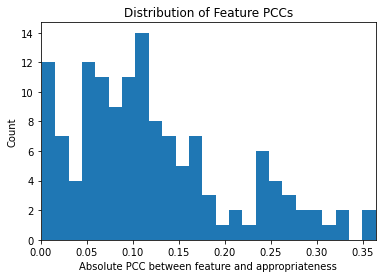

In [53]:
bins = 25
plt.hist(abs_pcc_vals, bins = bins)
plt.xlim(0,max(abs_pcc_vals))
plt.xlabel("Absolute PCC between feature and appropriateness")
plt.ylabel("Count")
plt.title("Distribution of Feature PCCs")

In [54]:
XX.loc[np.array(['Cond_N' not in idx for idx in XX.index]) & np.array(['Cond_M' not in idx for idx in XX.index])]

,Spine1_jerks,Spine2_jerks,Spine3_jerks,LeftShoulder_jerks,LeftArm_jerks,LeftForearm_jerks,LeftHand_jerks,RightShoulder_jerks,RightArm_jerks,RightForearm_jerks,...,RightShoulder_RMS_Distance_Score,RightArm_RMS_Distance_Score,RightForeArm_RMS_Distance_Score,RightHand_RMS_Distance_Score,Neck_RMS_Distance_Score,Neck1_RMS_Distance_Score,Head_RMS_Distance_Score,min_RMS_Energy,max_RMS_Energy,mean_RMS_Energy
idx,,,,,,,,,,,,,,,,,,,,,
Cond_BA/StudySeq1,4.685833,5.411104,5.878632,6.194287,6.654608,7.431837,8.474055,6.194249,6.474088,7.639084,...,-0.883697,-0.720384,-0.725393,-0.405569,-0.877568,-0.900200,-0.897108,-7.443251,-2.481649,-3.431537
Cond_BA/StudySeq2,4.794414,5.491201,5.933963,6.253794,6.713159,7.475203,8.674891,6.253755,6.409670,7.597684,...,-0.634781,-0.490504,-0.701013,-0.364630,-0.611639,-0.624665,-0.621450,-6.103462,-2.012080,-3.357033
Cond_BA/StudySeq3,4.641790,5.373085,5.848681,6.152784,6.634901,7.446747,8.324778,6.152773,6.423095,7.634566,...,-0.961857,-0.839776,-0.697355,-0.379593,-0.964247,-0.998867,-0.995880,-6.900108,-2.392672,-3.799317
Cond_BA/StudySeq4,4.542846,5.256153,5.713922,6.057099,6.488468,7.652750,8.665599,6.057132,6.482450,8.016873,...,-0.817813,-0.592928,-0.706693,-0.388299,-0.814075,-0.817477,-0.791424,-7.475503,-2.448848,-3.595032
Cond_BA/StudySeq5,4.344198,5.028202,5.490168,5.835539,6.388440,7.772797,8.492025,5.835528,6.345554,8.034707,...,-0.875800,-0.718347,-0.729312,-0.403087,-0.872548,-0.898013,-0.893621,-7.424981,-2.220725,-3.847157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cond_SE/StudySeq36,4.967658,5.675472,6.141858,6.474946,6.803089,7.614594,8.627233,6.474991,6.756016,7.909899,...,-0.862010,-0.640253,-0.729041,-0.302450,-0.852867,-0.856264,-0.844969,-7.093804,-2.782008,-4.132883
Cond_SE/StudySeq37,5.223548,5.940617,6.413427,6.708183,6.957730,7.672844,8.686264,6.708236,6.932257,7.830544,...,-0.814639,-0.664621,-0.732615,-0.407942,-0.801910,-0.813247,-0.803353,-7.536428,-3.115141,-4.425146
Cond_SE/StudySeq38,4.905687,5.614416,6.066102,6.359770,6.649041,7.214690,8.159950,6.359816,6.534368,7.303212,...,-0.876519,-0.662159,-0.709351,-0.395707,-0.876576,-0.896846,-0.887541,-7.799489,-2.971026,-4.295128


Plots of Highest and Lowest Correlated Features vs Appropriateness Scores

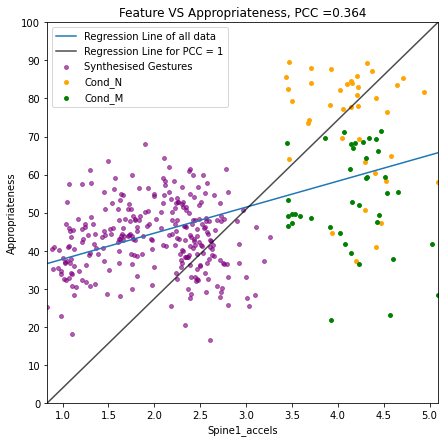

In [55]:
# Highest Plots
n = 1 # n highest plots
for i in range(0,n):
    idx = -1 - i
    pcc = pcc_vals[np.where(XX.columns == sorted_features[idx][0])[0][0]]
    feature = sorted_features[idx][0]
    
    m, b = np.polyfit(XX[feature], YY, 1)
    x = np.linspace(np.min(XX[feature]), np.max(XX[feature]), 101)
    y = np.arange(0,101)
    
    plt.figure(figsize = (7,7))
    plt.plot(x, m*x + b, label="Regression Line of all data")
    plt.plot(x, y, "-k", label="Regression Line for PCC = 1", alpha=0.7)
    plt.scatter(XX.loc[np.array(['Cond_N' not in idx for idx in XX.index]) & np.array(['Cond_M' not in idx for idx in XX.index])][feature], 
                YY.loc[np.array(['Cond_N' not in idx for idx in YY.index]) & np.array(['Cond_M' not in idx for idx in YY.index])], 
                s=15, c='purple', alpha=0.6, label='Synthesised Gestures')
    plt.scatter(XX.loc[['Cond_N' in idx for idx in XX.index]][feature], YY.loc[['Cond_N' in idx for idx in YY.index]], s=15, c='orange',
               label='Cond_N')
    plt.scatter(XX.loc[['Cond_M' in idx for idx in XX.index]][feature], YY.loc[['Cond_M' in idx for idx in YY.index]], s=15, c='green',
               label='Cond_M')
    plt.ylim(0,100)
    plt.xlim(min(XX[feature]), max(XX[feature]))
    plt.ylabel('Appropriateness')
    plt.xlabel(feature)
    plt.yticks(np.linspace(0,100,11))
    plt.title("Feature VS Appropriateness, PCC =" + str(round(pcc,3)))
    plt.legend()
    plt.show()

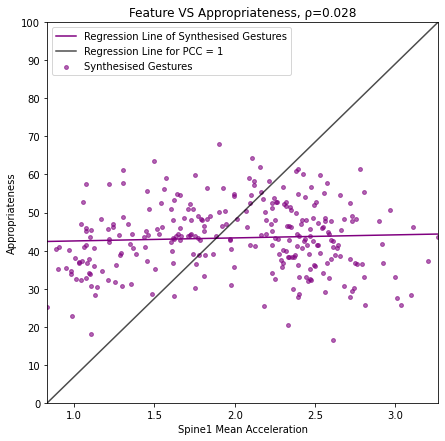

In [56]:
# Highest Plots
n = 1 # n highest plots
for i in range(0,n):
    idx = -1 - i
    pcc = pcc_vals[np.where(XX.columns == sorted_features[idx][0])[0][0]]
    feature = sorted_features[idx][0]
    
    X = XX.loc[np.array(['Cond_N' not in idx for idx in XX.index]) & np.array(['Cond_M' not in idx for idx in XX.index])][feature]
    Y = YY.loc[np.array(['Cond_N' not in idx for idx in YY.index]) & np.array(['Cond_M' not in idx for idx in YY.index])]
    
    m, b = np.polyfit(X, Y, 1)
    x = np.linspace(np.min(X), np.max(X), 101)
    y = np.arange(0,101)
    
    plt.figure(figsize = (7,7))
    plt.plot(x, m*x + b, label="Regression Line of Synthesised Gestures", c='purple')
    plt.plot(x, y, "-k", label="Regression Line for PCC = 1", alpha=0.7)
    plt.scatter(XX.loc[np.array(['Cond_N' not in idx for idx in XX.index]) & np.array(['Cond_M' not in idx for idx in XX.index])][feature], 
                YY.loc[np.array(['Cond_N' not in idx for idx in YY.index]) & np.array(['Cond_M' not in idx for idx in YY.index])], 
                s=15, c='purple', alpha=0.6, label='Synthesised Gestures')
    
    rho, pval = stats.spearmanr(Y, X)
    plt.ylim(0,100)
    plt.xlim(min(X), max(X))
    plt.ylabel('Appropriateness')
    plt.xlabel(feature)
    plt.yticks(np.linspace(0,100,11))
    plt.title("Feature VS Appropriateness, " + chr(961) + "=" + str(round(rho,3)))
    plt.legend()
plt.xlabel('Spine1 Mean Acceleration')
plt.show()

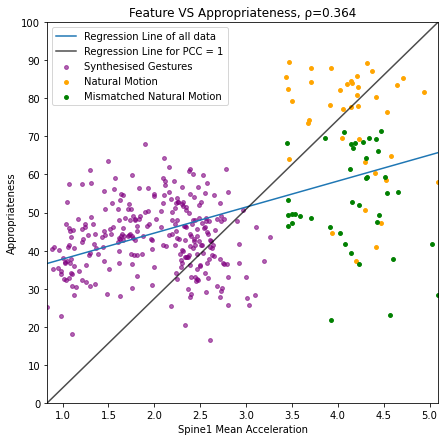

In [57]:
# Highest Plots
n = 1 # n highest plots
for i in range(0,n):
    idx = -1 - i
    pcc = pcc_vals[np.where(XX.columns == sorted_features[idx][0])[0][0]]
    feature = sorted_features[idx][0]
    
    m, b = np.polyfit(XX[feature], YY, 1)
    x = np.linspace(np.min(XX[feature]), np.max(XX[feature]), 101)
    y = np.arange(0,101)
    
    plt.figure(figsize = (7,7))
    plt.plot(x, m*x + b, label="Regression Line of all data")
    plt.plot(x, y, "-k", label="Regression Line for PCC = 1", alpha=0.7)
    plt.scatter(XX.loc[np.array(['Cond_N' not in idx for idx in XX.index]) & np.array(['Cond_M' not in idx for idx in XX.index])][feature], 
                YY.loc[np.array(['Cond_N' not in idx for idx in YY.index]) & np.array(['Cond_M' not in idx for idx in YY.index])], 
                s=15, c='purple', alpha=0.6, label='Synthesised Gestures')
    plt.scatter(XX.loc[['Cond_N' in idx for idx in XX.index]][feature], YY.loc[['Cond_N' in idx for idx in YY.index]], s=15, c='orange',
               label='Natural Motion')
    plt.scatter(XX.loc[['Cond_M' in idx for idx in XX.index]][feature], YY.loc[['Cond_M' in idx for idx in YY.index]], s=15, c='green',
               label='Mismatched Natural Motion')
    plt.ylim(0,100)
    plt.xlim(min(XX[feature]), max(XX[feature]))
    plt.ylabel('Appropriateness')
    plt.xlabel(feature)
    plt.yticks(np.linspace(0,100,11))
    plt.title("Feature VS Appropriateness, " + chr(961) + "=" + str(round(pcc,3)))
    plt.legend()
plt.xlabel('Spine1 Mean Acceleration')
plt.show()

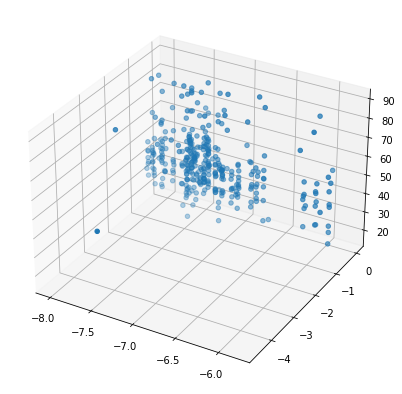

In [58]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(XX['min_RMS_Energy'], XX['Spine1_RMS_Distance_Score'], YY)

Text(0, 0.5, 'Spine1_RMS_Distance_Score')

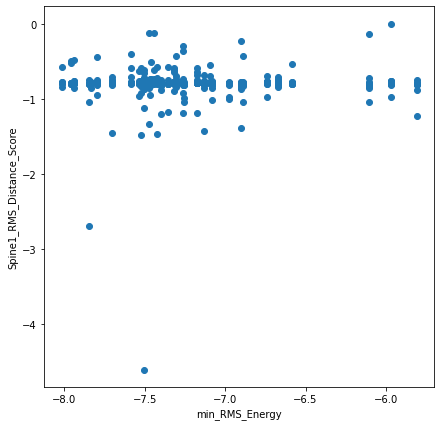

In [59]:
plt.figure(figsize = (7,7))
plt.scatter(XX['min_RMS_Energy'], XX['Spine1_RMS_Distance_Score'])
plt.xlabel('min_RMS_Energy')
plt.ylabel('Spine1_RMS_Distance_Score')

Text(0, 0.5, 'Spine2_RMS_Distance_Score')

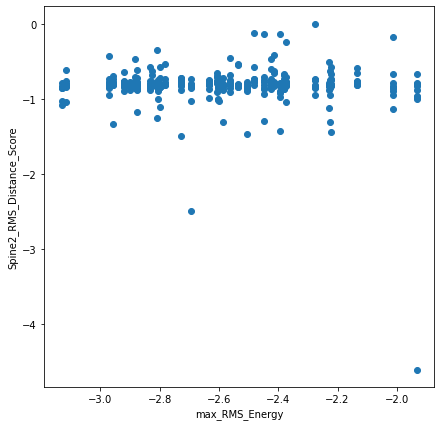

In [60]:
plt.figure(figsize = (7,7))
plt.scatter(XX['max_RMS_Energy'], XX['Spine2_RMS_Distance_Score'])
plt.xlabel('max_RMS_Energy')
plt.ylabel('Spine2_RMS_Distance_Score')

Text(0, 0.5, 'LeftShoulder_RMS_Distance_Score')

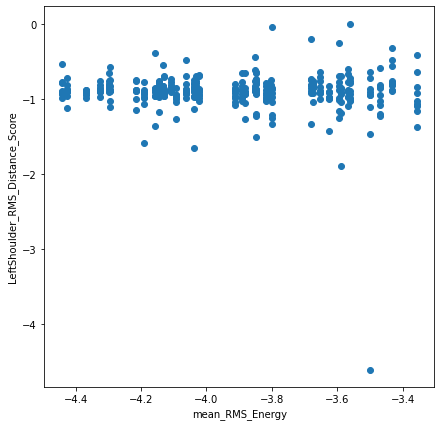

In [61]:
plt.figure(figsize = (7,7))
plt.scatter(XX['mean_RMS_Energy'], XX['LeftShoulder_RMS_Distance_Score'])
plt.xlabel('mean_RMS_Energy')
plt.ylabel('LeftShoulder_RMS_Distance_Score')

Text(0, 0.5, 'Spine2_RMS_Distance_Score')

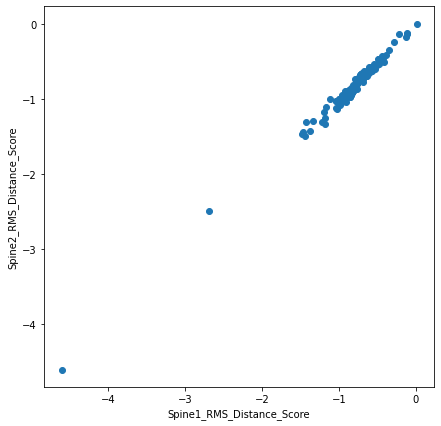

In [62]:
plt.figure(figsize = (7,7))
plt.scatter(XX['Spine1_RMS_Distance_Score'], XX['Spine2_RMS_Distance_Score'])
plt.xlabel('Spine1_RMS_Distance_Score')
plt.ylabel('Spine2_RMS_Distance_Score')

Text(0, 0.5, 'LeftShoulder_RMS_Distance_Score')

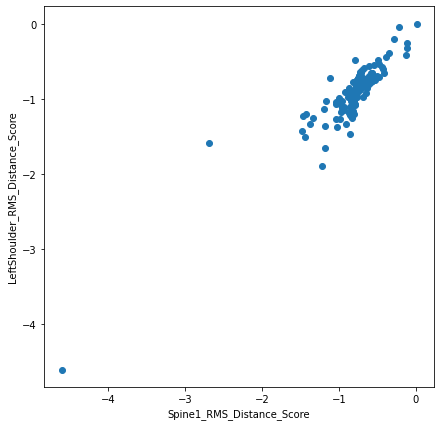

In [63]:
plt.figure(figsize = (7,7))
plt.scatter(XX['Spine1_RMS_Distance_Score'], XX['LeftShoulder_RMS_Distance_Score'])
plt.xlabel('Spine1_RMS_Distance_Score')
plt.ylabel('LeftShoulder_RMS_Distance_Score')

Text(0, 0.5, 'LeftShoulder_RMS_Distance_Score')

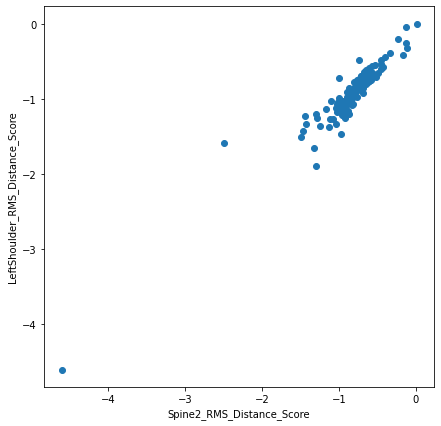

In [64]:
plt.figure(figsize = (7,7))
plt.scatter(XX['Spine2_RMS_Distance_Score'], XX['LeftShoulder_RMS_Distance_Score'])
plt.xlabel('Spine2_RMS_Distance_Score')
plt.ylabel('LeftShoulder_RMS_Distance_Score')

# Scaling effects

In [70]:
jerks_path = "Dataset/Appropriateness_Features/mean_jerk_values.csv"
XX_jerks = pd.read_csv(jerks_path) # With Spine joint and Name of "Cond/StudySeq"

accels_path = "Dataset/Appropriateness_Features/mean_acceleration_values.csv"
XX_accels = pd.read_csv(accels_path) # With Spine joint and Name of "Cond/StudySeq"

pairwise_path = "Dataset/Appropriateness_Features/mean_pairwise_joint_distances.csv"
XX_pairwise = pd.read_csv(pairwise_path) # With Spine joint and Name of "Cond/StudySeq"
XX_pairwise.drop(XX_pairwise.columns[range(1,15)], axis=1, inplace=True) # Without Spine Joint but with Name of "Cond/StudySeq"

rms_properties_path = "Dataset/Appropriateness_Features/RMS_Energy_properties.csv"
XX_rms_energy_properties = pd.read_csv(rms_properties_path, index_col = False) # With Name of StudySeq

rms_distance_path = "Dataset/Appropriateness_Features/RMS_Distance_scores_fd_scaled.csv"
XX_rms_distance_scores = pd.read_csv(rms_distance_path)
XX_rms_distance_scores.drop(XX_rms_distance_scores.columns[1], axis=1, inplace=True) # Dropping the Spine joint (always 0)

labels_path = "Dataset/Appropriateness_Labels/mean_opinion_scores.csv"
YY = pd.read_csv(labels_path) # # With Name of "Cond/StudySeq"

XY = XX_jerks.join(YY, lsuffix="_jerks", rsuffix="_YY")
XY = XY.join(XX_accels, rsuffix='_accels')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_accels'})
XY = XY.join(XX_pairwise, rsuffix='_pairwise')
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_pairwise'})
XY = XY.join(XX_rms_distance_scores)
XY = XY.rename(columns={'Unnamed: 0': 'Unnamed: 0_rms_distance_scores'})

# Join the RMS Energy Properties Features
XY = XY.rename(columns={'Unnamed: 0_jerks': 'StudySeq'})
XY['idx'] = XY['StudySeq']
XY['StudySeq'] = XY['StudySeq'].apply(lambda x: x[8:])
XY = XY.join(XX_rms_energy_properties, rsuffix='_rms')
for i in range(1,int(XY.shape[0]/40)):
    XY.iloc[i*40:(i+1)*40,-5:] = XX_rms_energy_properties

# Drop the Names of "Cond/StudySeq" and remaining information relating to the "Spine" joint
# Also Drop the Index from rms_energy
XY.drop(['StudySeq','Unnamed: 0_YY','Unnamed: 0_accels', 'Unnamed: 0_pairwise', 'Spine', 'Spine_accels',
        'Unnamed: 0_rms_distance_scores', 'Unnamed: 0', 'StudySeq_rms'], axis=1, inplace=True)

rename_dict = dict(zip(XY.columns[0:14], XY.columns[0:14] + '_jerks'))
XY = XY.rename(columns=rename_dict)
XY.set_index('idx', inplace=True)
# Jerk for 14 joints + Acceleration for 14 joints + 14 choose 2 pairwise distance + 14 RMS Energy Distance Scores + 3 RMS Energy Property Features + Label for MOS = 137
print(XY.shape)

XX = XY.drop(['Mean_Appropriateness_Score'], axis=1, inplace=False)
YY = XY.loc[:,'Mean_Appropriateness_Score']
print(XX.shape)
print(YY.shape)

(360, 137)
(360, 136)
(360,)


In [97]:
XX.iloc[:,30:].describe()

,Spine1_vs_LeftShoulder,Spine1_vs_LeftArm,Spine1_vs_LeftForeArm,Spine1_vs_LeftHand,Spine1_vs_RightShoulder,Spine1_vs_RightArm,Spine1_vs_RightForeArm,Spine1_vs_RightHand,Spine1_vs_Neck,Spine1_vs_Neck1,...,RightShoulder_RMS_Distance_Score,RightArm_RMS_Distance_Score,RightForeArm_RMS_Distance_Score,RightHand_RMS_Distance_Score,Neck_RMS_Distance_Score,Neck1_RMS_Distance_Score,Head_RMS_Distance_Score,min_RMS_Energy,max_RMS_Energy,mean_RMS_Energy
count,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,...,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000
mean,25.677063,31.919564,31.058607,39.443637,25.677118,31.717519,31.493395,41.497108,28.329258,35.310791,...,0.419781,0.501713,0.483248,0.672642,0.421117,0.414770,0.419772,0.000819,0.077704,0.020663
std,0.079035,1.398942,3.344699,4.182842,0.079096,1.498824,3.641405,4.423845,0.018757,0.049752,...,0.087002,0.110960,0.046010,0.053696,0.089042,0.091851,0.096835,0.000567,0.023538,0.006084
min,25.303478,27.494245,23.461719,26.882876,25.303012,27.113451,24.351457,27.930678,28.220748,35.108747,...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.000330,0.043689,0.011759
25%,25.646849,31.233962,28.885472,37.284624,25.646977,30.689681,28.933745,39.148301,28.325517,35.284986,...,0.388650,0.469355,0.473983,0.660182,0.386876,0.376920,0.379978,0.000542,0.059203,0.015984
50%,25.681703,32.187581,30.556922,39.191223,25.681676,32.008137,30.828769,41.194996,28.332318,35.321790,...,0.412938,0.495345,0.482121,0.669767,0.414201,0.407422,0.412721,0.000651,0.074171,0.020225
75%,25.711134,32.949960,32.726616,41.458161,25.711149,32.872348,33.411703,43.889311,28.337120,35.341993,...,0.443603,0.531199,0.490600,0.681025,0.446461,0.443722,0.448878,0.000833,0.089968,0.025505
max,25.870285,34.611256,46.338886,55.700722,25.870768,34.345263,45.238057,53.860820,28.356550,35.426034,...,1.010000,1.010000,1.010000,1.010000,1.010000,1.010000,1.010000,0.003001,0.144698,0.034838


In [76]:
for i in XX.describe().loc['std']:
    print(i)

354.0065489380095
357.889244186799
431.52377279641064
542.2266892088142
760.0415441880147
2455.7198806896918
3603.864006565526
542.2386731756862
772.1864971858619
3599.250902922818
4908.584846919026
586.7342905375498
712.8609299262412
855.5555274037949
28.659600812661413
26.488889322019418
26.3392909503776
28.346718965870746
38.242368489983996
104.26051499361166
159.0816237503146
28.347267221407552
38.50910640777145
131.392022213421
190.67809020683723
28.98110240195382
32.58887543077563
37.618111647613055
1.1044352216537025e-05
0.002106443497960788
0.07903543246087201
1.3989417616574962
3.3446993327476773
4.18284193536684
0.07909615581289682
1.4988235337077638
3.641404938106433
4.423845331022079
0.01875685283047195
0.04975229163782172
0.08309464755110792
1.1044352216608111e-05
0.04266359670884502
1.1517368891235664
2.593833629857212
4.172668061091383
0.042727345966483365
1.2187980567069765
2.8463722256785613
4.0243834030858014
0.009410944096800456
0.042588185425184395
0.070734059680181

We compare RightHand_RMS_Distance_Score vs min_RMS_Energy, when scaling is used and when it isn't used.

We can see that when log scaling isn't used, their standard deviations differ by a factor of ~100.
When they use log scaling they only differ by a factor of ~2.

Text(0, 0.5, 'Min RMS Energy')

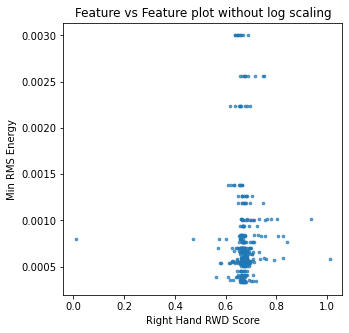

In [104]:
plt.figure(figsize=(5,5))
plt.scatter(XX.loc[:,'RightHand_RMS_Distance_Score'], XX.loc[:,'min_RMS_Energy'], s=7, alpha=0.7)
plt.title('Feature vs Feature plot without log scaling')
plt.xlabel('Right Hand RWD Score')
plt.ylabel('Min RMS Energy')

Text(0, 0.5, 'Min RMS Energy')

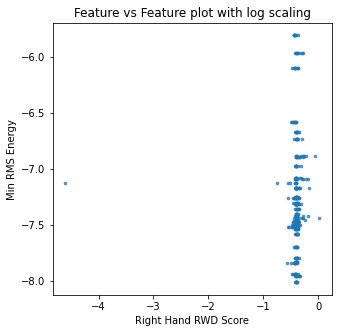

In [105]:
plt.figure(figsize=(5,5))
plt.scatter(np.log(XX.loc[:,'RightHand_RMS_Distance_Score']), np.log(XX.loc[:,'min_RMS_Energy']), s=7, alpha=0.7)
plt.title('Feature vs Feature plot with log scaling')
plt.xlabel('Right Hand RWD Score')
plt.ylabel('Min RMS Energy')

In [96]:
print('STD of Right Hand RWD Score with log scalling: ', np.std(np.log(XX.loc[:,'RightHand_RMS_Distance_Score'])))
print('STD of min RMS Energy with log scalling: ', np.std(np.log(XX.loc[:,'min_RMS_Energy'])))
print('STD of Right Hand RWD Score without log scalling: ', np.std(XX.loc[:,'RightHand_RMS_Distance_Score']))
print('STD of min RMS Energy without log scalling: ', np.std(XX.loc[:,'min_RMS_Energy']))

STD of Right Hand RWD Score with log scalling:  0.22885356949327254
STD of min RMS Energy with log scalling:  0.4993133748015937
STD of Right Hand RWD Score without log scalling:  0.05362130950565819
STD of min RMS Energy without log scalling:  0.0005664771570311756


Text(0, 0.5, 'Min RMS Energy')

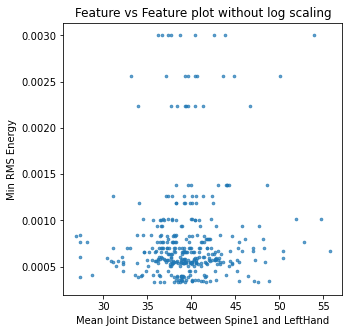

In [102]:
plt.figure(figsize=(5,5))
plt.scatter(XX.loc[:,'Spine1_vs_LeftHand'], XX.loc[:,'min_RMS_Energy'], s=7, alpha=0.7)
plt.title('Feature vs Feature plot without log scaling')
plt.xlabel('Mean Joint Distance between Spine1 and LeftHand')
plt.ylabel('Min RMS Energy')

Text(0, 0.5, 'Min RMS Energy')

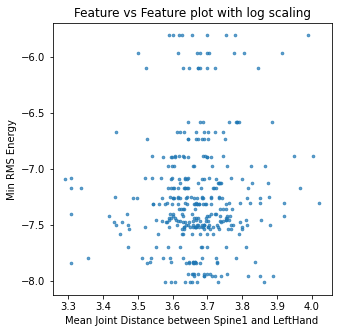

In [103]:
plt.figure(figsize=(5,5))
plt.scatter(np.log(XX.loc[:,'Spine1_vs_LeftHand']), np.log(XX.loc[:,'min_RMS_Energy']), s=7, alpha=0.7)
plt.title('Feature vs Feature plot with log scaling')
plt.xlabel('Mean Joint Distance between Spine1 and LeftHand')
plt.ylabel('Min RMS Energy')

In [101]:
print('STD of Spine1_vs_LeftHand with log scalling: ', np.std(np.log(XX.loc[:,'Spine1_vs_LeftHand'])))
print('STD of min RMS Energy with log scalling: ', np.std(np.log(XX.loc[:,'min_RMS_Energy'])))
print('STD of Spine1_vs_LeftHand without log scalling: ', np.std(XX.loc[:,'Spine1_vs_LeftHand']))
print('STD of min RMS Energy without log scalling: ', np.std(XX.loc[:,'min_RMS_Energy']))

STD of Spine1_vs_LeftHand with log scalling:  0.10652359562405722
STD of min RMS Energy with log scalling:  0.4993133748015937
STD of Spine1_vs_LeftHand without log scalling:  4.177028392688915
STD of min RMS Energy without log scalling:  0.0005664771570311756


In [85]:
np.std(np.log(XX.loc[:,'min_RMS_Energy']))

0.4993133748015937

In [86]:
np.std(XX.loc[:,'RightHand_RMS_Distance_Score'])

0.05362130950565819

In [95]:
np.std(XX.loc[:,'min_RMS_Energy'])

0.0005664771570311756